In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

from sklearn import preprocessing
import datetime

import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier

import seaborn as sns

from datetime import timedelta
from pylab import rcParams

from xgboost import plot_tree
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor



## Trabajaremos con la estación MGH

Leemos los archivos por hora:

In [2]:
data_hora_12 = pd.read_csv('/home/paw/DanielBustillos/datasets/dia/cont_hora2012.csv')
data_hora_13 = pd.read_csv('/home/paw/DanielBustillos/datasets/dia/cont_hora2013.csv')
data_hora_14 = pd.read_csv('/home/paw/DanielBustillos/datasets/dia/cont_hora2014.csv')
data_hora_15 = pd.read_csv('/home/paw/DanielBustillos/datasets/dia/cont_hora2015.csv')
data_hora_16 = pd.read_csv('/home/paw/DanielBustillos/datasets/dia/cont_hora2016.csv')
data_hora_17 = pd.read_csv('/home/paw/DanielBustillos/datasets/dia/cont_hora2017.csv')
#data_MGH_12 = pd.read_csv('/Users/danielbustillos/Documents/servicio/Contaminación PM10/Outputs/por_hora/cont_hora2018.csv')

In [3]:
data_hora_17 = data_hora_17.append(data_hora_16, ignore_index=True)
data_hora_17 = data_hora_17.append(data_hora_15, ignore_index=True)
data_hora_17 = data_hora_17.append(data_hora_14, ignore_index=True)
data_hora_17 = data_hora_17.append(data_hora_13, ignore_index=True)
data_hora_17 = data_hora_17.append(data_hora_12, ignore_index=True)

In [4]:
data_hora = data_hora_17

In [5]:
data_hora['dia'] = data_hora['fecha'].astype(str).str[8:10]
data_hora['mes'] =  data_hora['fecha'].astype(str).str[5:7]

In [6]:
data_hora['fecha'] = data_hora['fecha'].astype(str).str[0:10]

In [7]:
data_hora = data_hora.drop(["Unnamed: 0"],axis=1)
data_hora = data_hora.drop_duplicates()
data_hora = data_hora[1::]

In [8]:
data_hora = data_hora.groupby(['fecha',"dia","hora","mes"])[ 'UVA', 'UVB',
       'PA', 'CO', 'NO', 'NO2', 'NOX', 'O3', 'PM2.5', 'PMCO', 'SO2', 'RH',
       'TMP', 'WSP', 'WDR', 'PM10'].mean()
data_hora.reset_index(inplace=True)


# Promedio Diario

In [9]:
data_mean = data_hora.groupby(['fecha'])['UVA', 'UVB', 'PA', 'CO', 'NO', 'NO2',
       'NOX', 'O3', 'PM2.5', 'PMCO', 'SO2', 'RH', 'TMP', 'WSP', 'WDR', 'PM10'].mean()
data_mean.reset_index(inplace=True)

In [10]:
data_min = data_hora.groupby(['fecha'])["TMP","PM10","RH","PA","UVB","UVA"].min()
data_min.reset_index(inplace=True)

In [11]:
data_max = data_hora.groupby(['fecha'])["TMP","PM10","RH","PA","UVB","UVA"].max()
data_max.reset_index(inplace=True)

In [12]:
data_day = pd.merge(data_min, data_max, on=["fecha"])
data_day = pd.merge(data_day, data_mean, on=["fecha"])

## Añadimos Precipitación que solo esta en días:

## Precipitación

In [13]:
prec_2017 = pd.read_excel('/home/paw/DanielBustillos/datasets/precipitacion/2017PPH.xls')
prec_2016 = pd.read_excel('/home/paw/DanielBustillos/datasets/precipitacion/2016PPH.xls')
prec_2015 = pd.read_excel('/home/paw/DanielBustillos/datasets/precipitacion/2015PPH.xls')
prec_2014 = pd.read_excel('/home/paw/DanielBustillos/datasets/precipitacion/2014PPH.xls')
prec_2013 = pd.read_excel('/home/paw/DanielBustillos/datasets/precipitacion/2013PPH.xls')
prec_2012 = pd.read_excel('/home/paw/DanielBustillos/datasets/precipitacion/2012PPH.xls')

In [14]:
prec_2017 = prec_2017.append(prec_2016, ignore_index=True)
prec_2017 = prec_2017.append(prec_2015, ignore_index=True)
prec_2017 = prec_2017.append(prec_2014, ignore_index=True)
prec_2017 = prec_2017.append(prec_2013, ignore_index=True)
prec_2017 = prec_2017.append(prec_2012, ignore_index=True)

In [15]:
prec = prec_2017

Los valores vacíos vienen como -99, vamos a eliminarlos:

In [16]:
prec = prec.where(prec.LOM != -99.00)

In [17]:
prec = prec.dropna()

Renombramos algunas columnas:

In [18]:
prec = prec.rename(columns={'FECHA': 'fecha'})

Transponemos el df:

In [19]:
prec = pd.melt(prec, id_vars=["fecha"], 
                   var_name="id_station",value_name="Precip")

In [20]:
prec['fecha'] =  pd.to_datetime(prec['fecha'], format='%Y-%m-%d %H:%M')

Lo unimos con el archivo ya generadio:

In [21]:
data_day["fecha"] =  pd.to_datetime(data_day["fecha"], format='%Y-%m-%d %H:%M')

In [22]:
data_day_avg = pd.merge(data_day, prec, on=["fecha"],  how='left')

In [23]:
data_day_avg = data_day_avg.fillna(0)

In [24]:
data_day_avg["dia"] = pd.DatetimeIndex(data_day_avg['fecha']).day
data_day_avg["mes"] = pd.DatetimeIndex(data_day_avg['fecha']).month

In [25]:
data_day_avg.columns

Index(['fecha', 'TMP_x', 'PM10_x', 'RH_x', 'PA_x', 'UVB_x', 'UVA_x', 'TMP_y',
       'PM10_y', 'RH_y', 'PA_y', 'UVB_y', 'UVA_y', 'UVA', 'UVB', 'PA', 'CO',
       'NO', 'NO2', 'NOX', 'O3', 'PM2.5', 'PMCO', 'SO2', 'RH', 'TMP', 'WSP',
       'WDR', 'PM10', 'id_station', 'Precip', 'dia', 'mes'],
      dtype='object')

### Limpiemos los outliers

In [26]:
data_day_avg = data_day_avg[data_day_avg.PM10_y<200]

In [27]:
data_hour_merge_24 = data_day_avg

In [28]:
data_hour_merge_24["PM10_24"] = data_hour_merge_24.PM10_y.shift(1)
data_hour_merge_24["PM10_1_a"] = data_hour_merge_24.PM10.shift(-1)
data_hour_merge_24["PM10_2_a"] = data_hour_merge_24.PM10.shift(-2)
data_hour_merge_24["PM10_3_a"] = data_hour_merge_24.PM10.shift(-3)
data_hour_merge_24["PM10_4_a"] = data_hour_merge_24.PM10.shift(-4)

data_hour_merge_24["PM10_2_y"] = data_hour_merge_24.PM10_y.shift(-2)
data_hour_merge_24["PM10_3_y"] = data_hour_merge_24.PM10_y.shift(-3)
data_hour_merge_24["PM10_4_y"] = data_hour_merge_24.PM10_y.shift(-4)


data_hour_merge_24["PM10_24"] = data_hour_merge_24.PM10_y.shift(-1)
data_hour_merge_24["PM10_24_x"] = data_hour_merge_24.PM10_x.shift(1)
data_hour_merge_24["temp_24"] = data_hour_merge_24.TMP.shift(-1)
data_hour_merge_24["pre_24"] = data_hour_merge_24.PA.shift(-1)
data_hour_merge_24["RH_24"] = data_hour_merge_24.RH_y.shift(-1)
data_hour_merge_24["RH_24_2"] = data_hour_merge_24.RH_y.shift(-2)

data_hour_merge_24["RH_24"] = data_hour_merge_24.RH_y.shift(-1)
data_hour_merge_24["RH_24_2"] = data_hour_merge_24.RH_y.shift(-2)

data_hour_merge_24["UVB_x_1"] = data_hour_merge_24.UVB_x.shift(-1)
data_hour_merge_24["UVB_x_2"] = data_hour_merge_24.UVB_x.shift(-2)
data_hour_merge_24["UVB_y_1"] = data_hour_merge_24.UVB_y.shift(-1)
data_hour_merge_24["UVB_y_2"] = data_hour_merge_24.UVB_y.shift(-2)

#data_MGH_18 = data_MGH_18.iloc[:,:-6]

In [29]:
data_day_avg.columns

Index(['fecha', 'TMP_x', 'PM10_x', 'RH_x', 'PA_x', 'UVB_x', 'UVA_x', 'TMP_y',
       'PM10_y', 'RH_y', 'PA_y', 'UVB_y', 'UVA_y', 'UVA', 'UVB', 'PA', 'CO',
       'NO', 'NO2', 'NOX', 'O3', 'PM2.5', 'PMCO', 'SO2', 'RH', 'TMP', 'WSP',
       'WDR', 'PM10', 'id_station', 'Precip', 'dia', 'mes', 'PM10_24',
       'PM10_1_a', 'PM10_2_a', 'PM10_3_a', 'PM10_4_a', 'PM10_2_y', 'PM10_3_y',
       'PM10_4_y', 'PM10_24_x', 'temp_24', 'pre_24', 'RH_24', 'RH_24_2',
       'UVB_x_1', 'UVB_x_2', 'UVB_y_1', 'UVB_y_2'],
      dtype='object')

In [30]:
data_hour_merge_24 = data_hour_merge_24[["dia" ,"mes", 'TMP_x', 'PM10_x', 'RH_x', 'PA_x', 'UVB_x', 'UVA_x', 'TMP_y',
       'PM10_y', 'RH_y', 'PA_y', 'UVB_y', 'UVA_y', 'UVA', 'UVB', 'PA', 'CO',
       'NO', 'NO2', 'NOX', 'O3', 'PM2.5', 'PMCO', 'SO2', 'RH', 'TMP', 'WSP',
       'WDR', 'PM10', 'Precip', 'PM10_24_x', 'temp_24', 'pre_24', 'RH_24',
       'RH_24_2', 'UVB_x_1', 'UVB_x_2', 'UVB_y_1', 'UVB_y_2',
       'PM10_1_a', 'PM10_2_a', 'PM10_3_a', 'PM10_4_a', 'PM10_2_y', 'PM10_3_y',
       'PM10_4_y','PM10_24']]

In [31]:
data_hour_merge_24 = data_hour_merge_24.dropna(how='any')

In [32]:
data_hour_merge_24['dia'] = data_hour_merge_24['dia'].astype(str).astype(float)
data_hour_merge_24['mes'] = data_hour_merge_24['mes'].astype(str).astype(float)

In [33]:
data_hour_merge_24.head()

,dia,mes,TMP_x,PM10_x,RH_x,PA_x,UVB_x,UVA_x,TMP_y,PM10_y,...,UVB_y_1,UVB_y_2,PM10_1_a,PM10_2_a,PM10_3_a,PM10_4_a,PM10_2_y,PM10_3_y,PM10_4_y,PM10_24
2,3.0,1.0,7.1,23.0,35.0,587.0,0.0,0.0,16.4,87.0,...,2.522,2.320,70.875000,60.541667,84.166667,58.625000,85.0,176.0,95.0,112.0
3,4.0,1.0,5.7,39.0,27.0,585.0,0.0,0.0,20.1,112.0,...,2.320,2.473,60.541667,84.166667,58.625000,57.045455,176.0,95.0,129.0,85.0
4,5.0,1.0,8.4,38.0,27.0,584.0,0.0,0.0,19.6,85.0,...,2.473,2.683,84.166667,58.625000,57.045455,59.750000,95.0,129.0,99.0,176.0
6,7.0,1.0,8.0,59.0,17.0,584.0,0.0,0.0,20.9,176.0,...,2.683,2.686,58.625000,57.045455,59.750000,52.750000,129.0,99.0,105.0,95.0
7,8.0,1.0,8.9,30.0,20.0,583.0,0.0,0.0,23.1,95.0,...,2.686,2.646,57.045455,59.750000,52.750000,68.300000,99.0,105.0,118.0,129.0


## Visualizaciones    <a class="anchor" id="viz-bullet"></a>


# XGBOOST <a class="anchor" id="fourth-bullet"></a>

## Filtros

## Definimos los conjuntos de prueba y Test

## Delay 24 Horas<a class="anchor" id="5-bullet"></a>
### XGBOOOST

In [34]:
X, y = data_hour_merge_24.iloc[:,:-1],data_hour_merge_24.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=123)

## SVM - Regresión

In [35]:
data_hour_merge_24.head()

,dia,mes,TMP_x,PM10_x,RH_x,PA_x,UVB_x,UVA_x,TMP_y,PM10_y,...,UVB_y_1,UVB_y_2,PM10_1_a,PM10_2_a,PM10_3_a,PM10_4_a,PM10_2_y,PM10_3_y,PM10_4_y,PM10_24
2,3.0,1.0,7.1,23.0,35.0,587.0,0.0,0.0,16.4,87.0,...,2.522,2.320,70.875000,60.541667,84.166667,58.625000,85.0,176.0,95.0,112.0
3,4.0,1.0,5.7,39.0,27.0,585.0,0.0,0.0,20.1,112.0,...,2.320,2.473,60.541667,84.166667,58.625000,57.045455,176.0,95.0,129.0,85.0
4,5.0,1.0,8.4,38.0,27.0,584.0,0.0,0.0,19.6,85.0,...,2.473,2.683,84.166667,58.625000,57.045455,59.750000,95.0,129.0,99.0,176.0
6,7.0,1.0,8.0,59.0,17.0,584.0,0.0,0.0,20.9,176.0,...,2.683,2.686,58.625000,57.045455,59.750000,52.750000,129.0,99.0,105.0,95.0
7,8.0,1.0,8.9,30.0,20.0,583.0,0.0,0.0,23.1,95.0,...,2.686,2.646,57.045455,59.750000,52.750000,68.300000,99.0,105.0,118.0,129.0


In [36]:
clf = SVR( C=100000.0, epsilon=50)
clf.fit(X_train, y_train)

SVR(C=100000.0, cache_size=200, coef0=0.0, degree=3, epsilon=50, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [37]:
preds_test = clf.predict(X_test)

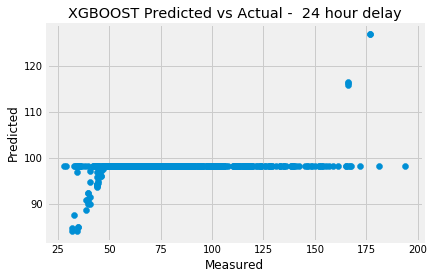

In [38]:
plt.scatter(y_test, preds_test)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('XGBOOST Predicted vs Actual -  24 hour delay')
plt.show()

In [39]:
clf.score(X_test, y_test)

-0.17967117453182468

In [40]:
rmse = np.sqrt(mean_squared_error(y_test, preds_test))
print("RMSE: %f" % (rmse))

RMSE: 33.224902


## Linear

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Create linear regression object
regr = LinearRegression()

In [42]:
# Train the model using the training sets
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [43]:
# Make predictions using the testing set
lin_pred = regr.predict(X_test)

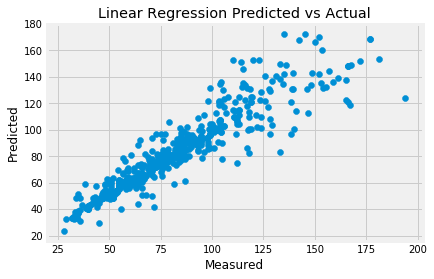

In [44]:
plt.scatter(y_test, lin_pred)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Linear Regression Predicted vs Actual')
plt.show()

In [45]:
regr.score(X_test, y_test)

0.8574108425742659

## Neural Network Regression

In [46]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Create MLPRegressor object
mlp = MLPRegressor( alpha=900.001, max_iter=100000,power_t=301, epsilon=.100 ,tol=.0001)
# Train the model using the training sets
mlp.fit(X_train, y_train)

MLPRegressor(activation='relu', alpha=900.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=0.1,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=100000, momentum=0.9,
       nesterovs_momentum=True, power_t=301, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

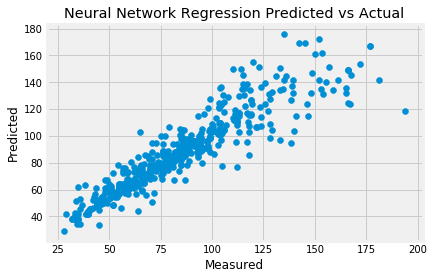

In [47]:
# Score the model
neural_network_regression_score = mlp.score(X_test, y_test)
neural_network_regression_score
# Make predictions using the testing set
nnr_pred = mlp.predict(X_test)
# The mean squared error

plt.scatter(y_test, nnr_pred)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Neural Network Regression Predicted vs Actual')
plt.show()

In [48]:
xgb_score = mlp.score(X_test, y_test)
xgb_score

0.8472409194053359

# XGBoost

In [ ]:
regr_2 = AdaBoostRegressor(XGBRegressor(learning_rate = .0015, n_estimators=3000, max_depth=10),n_estimators=100)
regr_2.fit(X_train, y_train)

In [ ]:
1+1

In [ ]:
ADAXGB_pred = regr_2.predict(X_test)

In [ ]:
plt.scatter(y_test, ADAXGB_pred)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('XGBoost Predicted vs Actual')
plt.show()

In [ ]:
xgb_score = regr_2.score(X_test, y_test)
xgb_score

## XGBOOST

In [49]:
from xgboost.sklearn import XGBRegressor

#Fitting XGB regressor 
xboost = XGBRegressor(learning_rate = .0015, n_estimators=3000, max_depth=10)

In [50]:
xboost.fit(X_train, y_train)
xgb_score = xboost.score(X_test, y_test)

/home/paw/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [51]:
#Predict 
xboost_pred = xboost.predict(X_test)

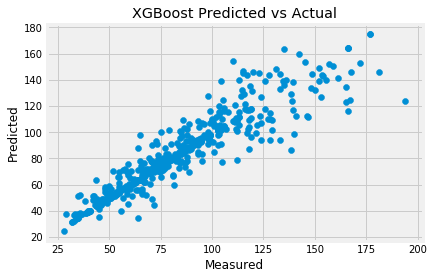

In [52]:
plt.scatter(y_test, xboost_pred)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('XGBoost Predicted vs Actual')
plt.show()

In [53]:
xgb_score = xboost.score(X_test, y_test)
xgb_score

0.867550569319045

## Decission Tree

In [54]:
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=10,max_depth=3000)

In [55]:
regressor.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=3000, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=10, splitter='best')

In [56]:
xboost_pred = regressor.predict(X_test)

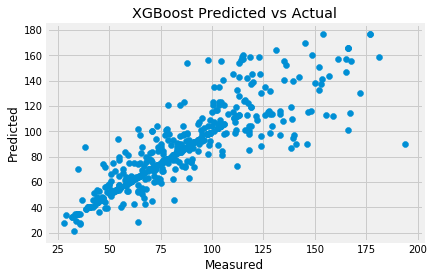

In [57]:
plt.scatter(y_test, xboost_pred)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('XGBoost Predicted vs Actual')
plt.show()

In [58]:
regressor.score(X_test, y_test)

0.7494131916094408

# ada

In [59]:
regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=40),n_estimators=3000)
regr_2.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=40, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=3000,
         random_state=None)

In [61]:
y_2 = regr_2.predict(X_test)

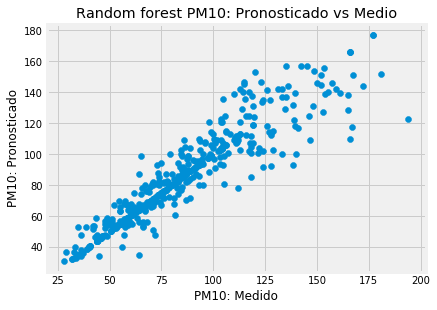

In [62]:
plt.scatter(y_test, y_2)
plt.tight_layout(1.3)
plt.xlabel('PM10: Medido')
plt.ylabel('PM10: Pronosticado')
plt.title('Random forest PM10: Pronosticado vs Medio')
plt.show()

In [63]:
regr_2.score(X_test, y_test)

0.8766258635363022

In [77]:
rmse = np.sqrt(mean_squared_error(y_test, regr_2.predict(X_test)))
print("RMSE: %f" % (rmse))

RMSE: 10.744725


# Gracficamos:

In [67]:
y_1 = regr_2.predict(X_test)


In [68]:
X, y = data_hour_merge_24.iloc[:,:-1],data_hour_merge_24.iloc[:,-1]

In [69]:
preds = y_1.tolist()

In [70]:
yi = y_test.tolist()

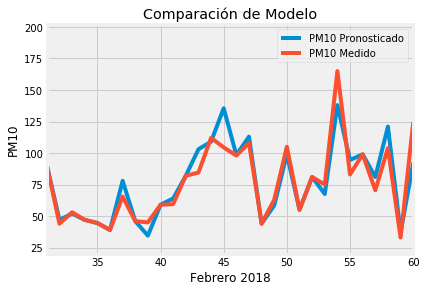

In [73]:
>>> plt.plot(preds ,label='PM10 Pronosticado')
>>> plt.plot(yi,label='PM10 Medido')
>>> plt.xlabel("Febrero 2018")
>>> plt.ylabel("PM10")
plt.tight_layout(1.3)
plt.title('Comparación de Modelo')
>>> plt.xlim(31, 60)
plt.legend()

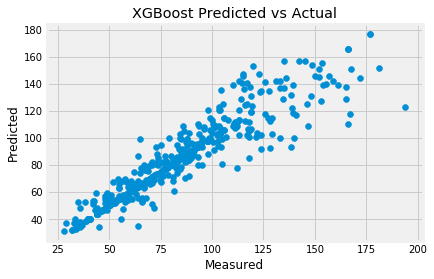

In [74]:
plt.scatter(y_test, y_2)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('XGBoost Predicted vs Actual')
plt.show()

In [75]:
rmse = np.sqrt(mean_squared_error(y_test, y_2))
print("RMSE: %f" % (rmse))

RMSE: 10.744725


In [78]:
1+1

2

## Random forest

In [79]:
>>> from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

>>> from sklearn.datasets import make_regression

In [80]:
regr = RandomForestRegressor(max_depth=35,n_estimators=500)
regr_fit = regr.fit(X_train, y_train)

In [81]:
y_1 = regr.predict(X_test)

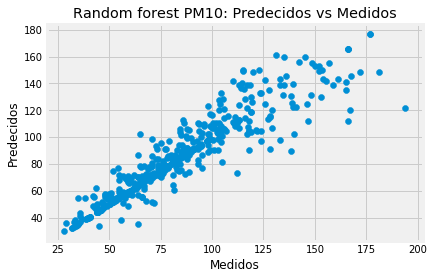

In [82]:
plt.scatter(y_test, y_1)
plt.xlabel('Medidos')
plt.ylabel('Predecidos')
plt.title('Random forest PM10: Predecidos vs Medidos')
plt.show()

In [83]:
regr.score(X_test, y_test)

0.8684885208527457

In [84]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(regr.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

In [85]:
importances[importances.importance > .01]

,importance
feature,
PM10_1_a,0.834
PM10_y,0.020
PM10_2_y,0.015
PM10_3_y,0.011


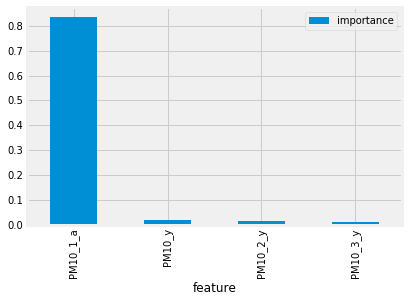

In [86]:
importances[importances.importance > .01].plot.bar()
